In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Функція для створення графа
def build_logistic_network():
    G = nx.DiGraph()

    # Список ребер з таблиці завдання
    edges = [
        # Термінали -> Склади
        ("Термінал 1", "Склад 1", 25), ("Термінал 1", "Склад 2", 20), ("Термінал 1", "Склад 3", 15),
        ("Термінал 2", "Склад 3", 15), ("Термінал 2", "Склад 4", 30), ("Термінал 2", "Склад 2", 10),
        # Склади -> Магазини
        ("Склад 1", "Магазин 1", 15), ("Склад 1", "Магазин 2", 10), ("Склад 1", "Магазин 3", 20),
        ("Склад 2", "Магазин 4", 15), ("Склад 2", "Магазин 5", 10), ("Склад 2", "Магазин 6", 25),
        ("Склад 3", "Магазин 7", 20), ("Склад 3", "Магазин 8", 15), ("Склад 3", "Магазин 9", 10),
        ("Склад 4", "Магазин 10", 20), ("Склад 4", "Магазин 11", 10), ("Склад 4", "Магазин 12", 15),
        ("Склад 4", "Магазин 13", 5), ("Склад 4", "Магазин 14", 10),
    ]

    for u, v, cap in edges:
        G.add_edge(u, v, capacity=cap)

    return G

In [3]:
# Функція для розрахунку максимального потоку
def calculate_max_flow(G):
    # Додавання Супер-Джерела (S) та Супер-Стоку (T)
    super_source = "Super_Source"
    super_sink = "Super_Sink"

    # З'єднуємо Супер-Джерело з Терміналами
    G.add_edge(super_source, "Термінал 1", capacity=float('inf'))
    G.add_edge(super_source, "Термінал 2", capacity=float('inf'))

    # З'єднуємо всі Магазини з Супер-Стоком
    stores = [node for node in G.nodes if "Магазин" in node]
    for store in stores:
        G.add_edge(store, super_sink, capacity=float('inf'))

    # Розрахунок алгоритмом Едмондса-Карпа з-під капоту Networkx, як лаконічне
    # готове рішення замість копіювання конспекта, але явно вказуємо використання
    # відповідного алгоритму
    flow_value, flow_dict = nx.maximum_flow(
        G, super_source, super_sink, flow_func=nx.algorithms.flow.edmonds_karp
    )

    # Видаляємо допоміжні вершини після розрахунку,
    # щоб вони не ламали візуалізацію та структуру основного графа
    G.remove_node(super_source)
    G.remove_node(super_sink)

    return flow_value, flow_dict


In [4]:
# Функція для візуалізації структури графа
def visualize_graph_structure(G):
    plt.figure(figsize=(14, 10))
    pos = {}

    # Сортування вузлів
    terminals = sorted([n for n in G.nodes if "Термінал" in n])
    warehouses = sorted([n for n in G.nodes if "Склад" in n])
    stores = sorted([n for n in G.nodes if "Магазин" in n], key=lambda x: int(x.split()[1]))

    # Розстановка (координати)
    for i, node in enumerate(terminals):
        pos[node] = (0, 0.5 + (len(terminals)-1-i)*0.2 - (len(terminals)-1)*0.1)

    for i, node in enumerate(warehouses):
        pos[node] = (1, 0.8 - i * 0.25)

    for i, node in enumerate(stores):
        pos[node] = (2, 0.95 - i * 0.07)

    # Кольори
    node_colors = []
    for node in G.nodes():
        if "Термінал" in node: node_colors.append('#FFD700')
        elif "Склад" in node: node_colors.append('#87CEEB')
        elif "Магазин" in node: node_colors.append('#90EE90')
        else: node_colors.append('#D3D3D3')

    # Малювання
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors='gray')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowstyle='-|>', arrowsize=20)

    edge_labels = {(u, v): f"{d['capacity']}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red', font_size=10)

    plt.title("Структура логістичної мережі (вихідні дані)", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
# Функція для візуалізації графа з потоком
def draw_network(G, flow_dict):
    plt.figure(figsize=(14, 10))
    pos = {}

    # Ті самі координати
    terminals = sorted([n for n in G.nodes if "Термінал" in n])
    warehouses = sorted([n for n in G.nodes if "Склад" in n])
    stores = sorted([n for n in G.nodes if "Магазин" in n], key=lambda x: int(x.split()[1]))

    for i, node in enumerate(terminals):
        pos[node] = (0, 0.5 + (len(terminals)-1-i)*0.2 - (len(terminals)-1)*0.1)
    for i, node in enumerate(warehouses):
        pos[node] = (1, 0.8 - i * 0.25)
    for i, node in enumerate(stores):
        pos[node] = (2, 0.95 - i * 0.07)

    # Кольори ребер на основі навантаження
    edge_colors = []
    edge_widths = []
    edge_labels = {}

    for u, v in G.edges():
        capacity = G[u][v]['capacity']
        current_flow = flow_dict.get(u, {}).get(v, 0)

        if current_flow == capacity and capacity > 0:
            edge_colors.append('red')       # 100% завантаження
            edge_widths.append(2.5)
        elif current_flow > 0:
            edge_colors.append('#66b3ff')   # Робочий потік
            edge_widths.append(1.5)
        else:
            edge_colors.append('#e0e0e0')   # Немає потоку
            edge_widths.append(1.0)

        edge_labels[(u, v)] = f"{current_flow}/{capacity}"

    # Кольори вузлів
    node_colors = []
    for node in G.nodes():
        if "Термінал" in node: node_colors.append('#ff9999')
        elif "Склад" in node: node_colors.append('#99ff99')
        elif "Магазин" in node: node_colors.append('#ffcc99')
        else: node_colors.append('#ccc')

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=2000, edgecolors='black')
    nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")
    nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=edge_widths, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black', font_size=8)

    plt.title("Логістична мережа: Аналіз вузьких місць\n(Червоні лінії = 100% завантаження)", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [6]:
# Функція для виведення результатів у вигляді таблиц
def print_results(flow_value, flow_dict):
    print(f"\n Максимальний потік через мережу: {flow_value} одиниць.\n")
    print("-" * 50)
    table_data = []
    warehouses = [n for n in flow_dict if "Склад" in n]

    for warehouse in warehouses:
        terminals_feeding = []
        if flow_dict.get("Термінал 1", {}).get(warehouse, 0) > 0:
            terminals_feeding.append("Термінал 1")
        if flow_dict.get("Термінал 2", {}).get(warehouse, 0) > 0:
            terminals_feeding.append("Термінал 2")

        terminal_str = " & ".join(terminals_feeding)

        for store, flow in flow_dict[warehouse].items():
            if flow > 0 and "Магазин" in store:
                table_data.append([terminal_str, store, flow])

    df = pd.DataFrame(table_data, columns=["Термінал", "Магазин", "Фактичний Потік"])
    df['Store_ID'] = df['Магазин'].apply(lambda x: int(x.split()[1]))
    df = df.sort_values('Store_ID').drop('Store_ID', axis=1)
    print(df.to_string(index=False))

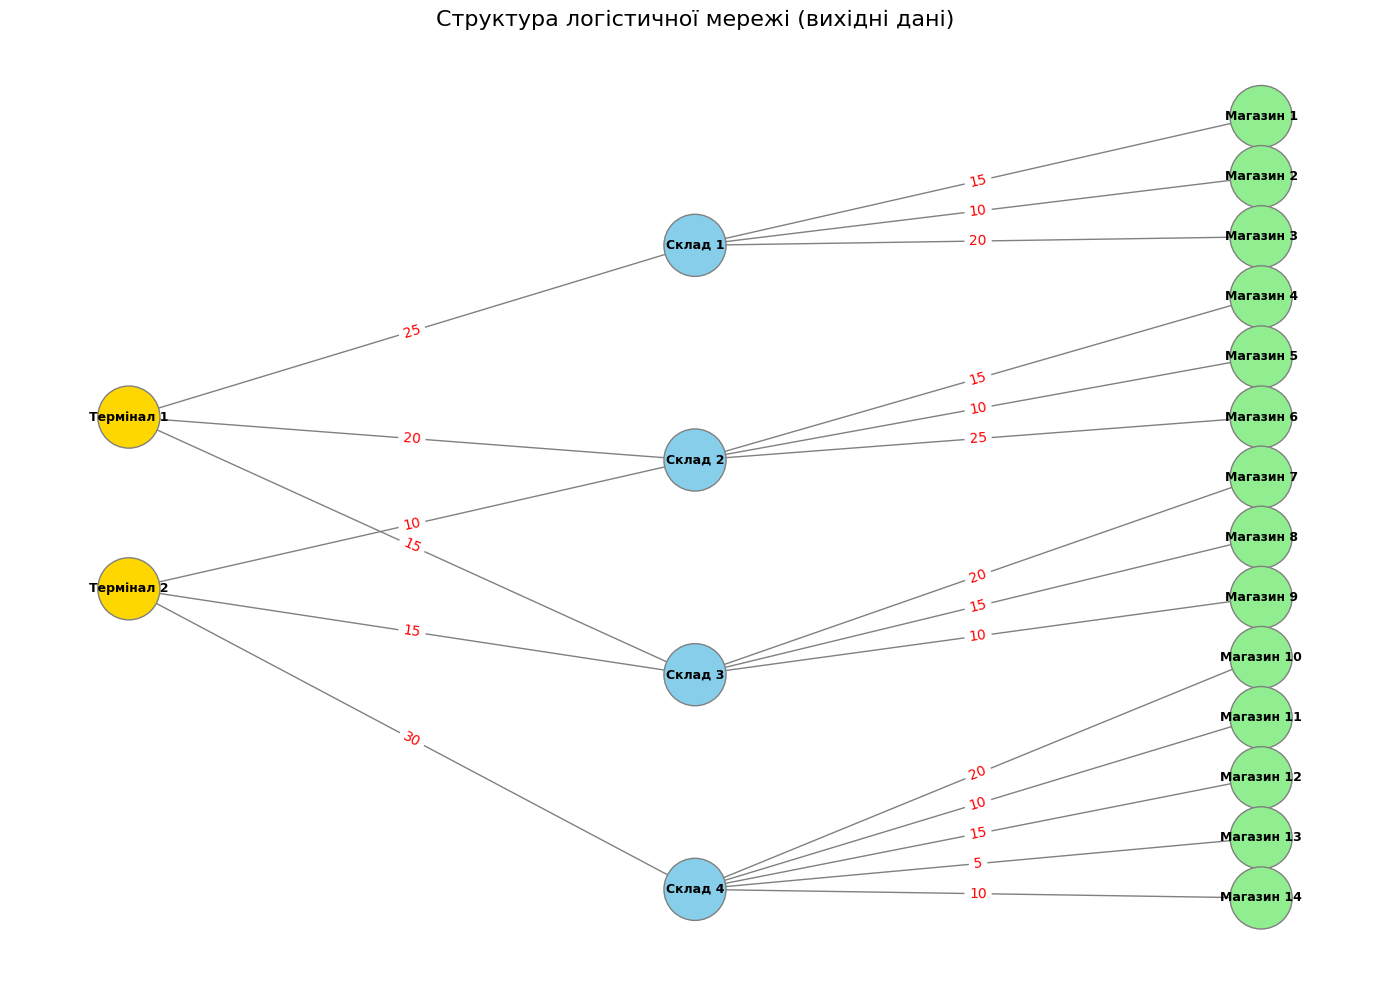


 Максимальний потік через мережу: 115 одиниць.

--------------------------------------------------
               Термінал    Магазин  Фактичний Потік
             Термінал 1  Магазин 1               15
             Термінал 1  Магазин 2               10
Термінал 1 & Термінал 2  Магазин 4               15
Термінал 1 & Термінал 2  Магазин 5               10
Термінал 1 & Термінал 2  Магазин 6                5
Термінал 1 & Термінал 2  Магазин 7               20
Термінал 1 & Термінал 2  Магазин 8               10
             Термінал 2 Магазин 10               20
             Термінал 2 Магазин 11               10


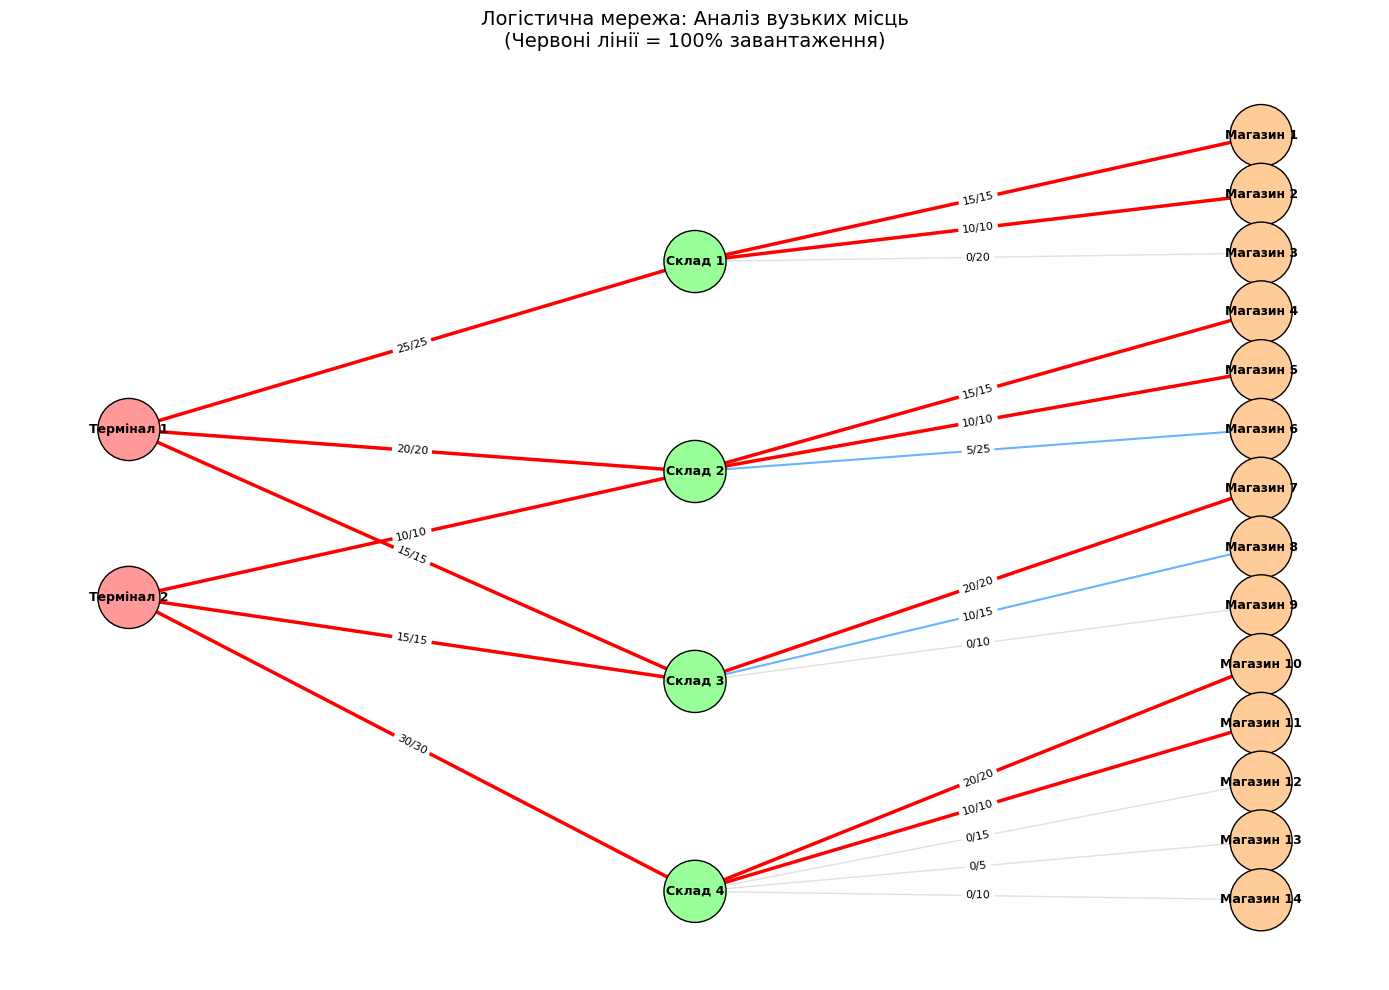

In [7]:
if __name__ == "__main__":
    # 1. Створюємо граф
    graph = build_logistic_network()

    # 2. Візуалізуємо структуру (до розрахунку)
    visualize_graph_structure(graph)

    # 3. Розраховуємо потік (і очищуємо граф від Super_Source всередині функції)
    max_flow_val, flows = calculate_max_flow(graph)

    # 4. Виводимо таблицю
    print_results(max_flow_val, flows)

    # 5. Візуалізуємо результати (тепер без помилки KeyError)
    draw_network(graph, flows)

# 1. Які термінали забезпечують найбільший потік товарів до магазинів?

Термінал 1 має більшу пропускну здатність зв'язків зі складами (60 одиниць проти 55 у Термінала 2). Однак обидва термінали працюють на межі своїх можливостей передачі на склади, оскільки попит магазинів значно перевищує можливості каналів постачання.

# 2. Які маршрути мають найменшу пропускну здатність і як це впливає на загальний потік?

Найбільш критичними є маршрути між Терміналами та Складами.

Термінал 1 -> Склад 1: Пропускна здатність 25, а потреба магазинів (М1, М2, М3) — 45. Це "вузьке місце", яке ріже потік на 20 одиниць.

Термінал 2 -> Склад 4: Пропускна здатність 30, а потреба магазинів (М10-М14) — 60. Потік ріжеться на 30 одиниць.

В обох випадках маємо незадоволені потреби магазинів за рахунок низької пропускної здатності ділянок Термінал -> Склад

# 3. Які магазини отримали найменше товарів і чи можна збільшити їх постачання, збільшивши пропускну здатність певних маршрутів?

Найменше товарів отримали магазини у групах, підключених до Складу 4 (Магазини 12, 13, 14, швидше за все, отримають 0 або мінімум) та Складу 1 (Магазин 3 недоотримає товар).

Чи можна збільшити? - Так, але тільки збільшивши пропускну здатність ребер "Термінал 1 -> Склад 1" та "Термінал 2 -> Склад 4". Збільшення каналів від складів до самих магазинів нічого не дасть, бо товар не доходить до складу в достатній кількості.

# 4. Чи є вузькі місця, які можна усунути для покращення ефективності логістичної мережі?

Так, основні вузькі місця знаходяться на вході у склади:

Т1 -> Склад 1: Розширення каналу з 25 до 45 дозволить повністю забезпечити Магазини 1, 2, 3.

Т2 -> Склад 4: Розширення каналу з 30 до 60 дозволить повністю забезпечити Магазини 10-14.

Склади 2 та 3: Також є дефіцит. Сумарний вхід на Склад 2 (20 від Т1 + 10 від Т2 = 30), а попит (15+10+25 = 50). Дефіцит 20 одиниць.